# CPPI
_Constant Proportion Portfolio Insurance_
* Allows for convex option-like payoffs without the use of options
* Allocate to a risky asset in multiple M of the difference between your asset value and a given floor.
* When the cushion (difference) decreases then less is allocated to risky assets

## Extensions to CPPI
* Protect the maximum drawdown floor
    * At any time the value of the portfolio will be greater than alpha percent of the maximum value
    * The maximum drawdown floor will adjust to increasing maximum value of the portfolio
* CPPI with performance cap
    * Protecting downside has an opportunity cost
    * Determine a threshold between the floor and the cap
        * When Asset value is between the floor and threshold = m (asset value at t - asset value of floor at t)
        * When Asset value is between the threshold and cap = m (asset value of cap at t - asset value at t)
        * = slowing down on the way down and slowing down on the way up
    * e.g initial allocation to the risky asset for a portfolio starting at $100, with a multiplier equal to 4, a wealth preservation floor set at 90% and a cap set at 105%?
        * -> Because it is closer to the cap 4 * (105 - 100) = 20%
    * How to pick the threshold value?
        * There is a smoothening out. When exactly at the threshold value threshold - floor is equal to cap - threshold. Therefore the threshold is half of the floor plus cap
    * Helpful strategy when investors have a specific target

# Implementing Potfolio Insurance (CPPI) and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from my_modules import risk
from my_modules import data
from my_modules import portfolio
from my_modules import index

from scipy.optimize import minimize
import numpy as np
import pandas as pd

In [4]:
ind_return = data.get_ind30_vw_returns()
industry_sizes = data.get_ind30_size()
num_firms = data.get_ind30_nfirms()
tmi_return = index.total_market_index(industry_sizes, num_firms, ind_return)

In [5]:
# Dynamically allocate between risky and safe asset so that it does not violate a floor constraint
risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']] 
risky_r.shape

(228, 3)

In [6]:
# Safe asset
# Provide a data frame with the same size
safe_r = pd.DataFrame().reindex_like(risky_r)

In [7]:
# Stuff with same values
safe_r[:] = 0.03/12
start = 1000
floor = 0.8

### Steps of algorithm
1. Cushion - (Asset Value - Floor Value)
2. Compute an allocation to safe and risky assets (m * risk budget)
3. Recompute Asset Value based on the returns
-> repeat

In [11]:
def compound1(r):
    return (1 + r).prod() -1

def compound2(r):
    # log(1+r) = log1p(r)
    return np.expm1(np.log1p(r).sum())

In [9]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [12]:
# Same numbers
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [13]:
%timeit compound1(risky_r)

1.7 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit compound2(risky_r)

459 µs ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
# Dates that are to be itterated over
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start * floor
m = 3

# Backtest, running the algorithm across past values
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_weight_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    # Don't lever or go short
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    ## Update account value for t
    account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
    ## Save values to plot history
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion
    risky_weight_history = risky_w

In [20]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


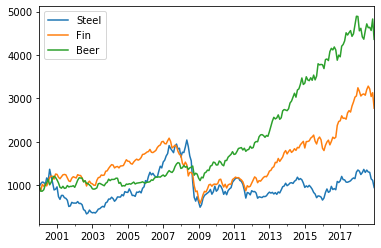

In [22]:
# Without CPPI
risky_wealth = start*(1 + risky_r).cumprod()
risky_wealth.plot()

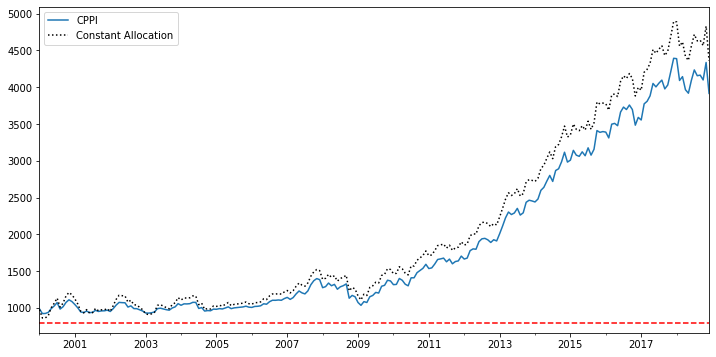

In [26]:
# Beer, constant allocation vs CPPI
ax = account_history['Beer'].plot(figsize=(12,6), label='CPPI', legend=True)
risky_wealth['Beer'].plot(ax=ax, style='k:', label='Constant Allocation', legend=True)
ax.axhline(y=floor_value, color='r', linestyle='--')


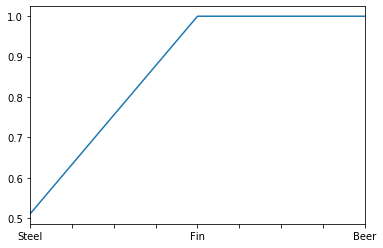

In [30]:
# The floor should be adjusted as after 2009 the risky allocation is set to 100%
risky_weight_history.plot()